# Training with UNet

In [1]:
import os
import math

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
import tensorflow.keras.losses as losses

def iou(y_true, y_pred):
    smooth = 0.
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    score = intersection / (union + smooth)
    return score


def dice_coef(y_true, y_pred):
    smooth = 0.
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)

    return loss


def bce_dice_loss(y_true, y_pred): #사용할 loss
    loss = 1.*losses.binary_crossentropy(y_true, y_pred) + 1.*dice_loss(y_true, y_pred)

    return loss

In [3]:
from tensorflow import keras
import albumentations as A
import cv2

class Augmentation: #이미지와 마스크에 적용
    def __init__(self, size, mode='train'):
        if mode == 'train':
            # Declare an augmentation pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask
        
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.fold = fold
        self.shuffle = shuffle
        self.mode = mode
        self.batch_size = batch_size
        self.image_size = image_size
        
        self.df = pd.read_csv(csv_path)
        if self.mode == 'train':    
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
    
        for _, r in data.iterrows():
            file_name = r['file_name']

            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            mask = cv2.imread(f'data/annotations/trimaps/{file_name}.png',
                              cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            mask[mask != 1] = 0
            
            if self.mode == 'train':
                #image = image.astype('uint8')
                image, mask = self.transform(image=image, mask=mask)
                
            image = image.astype('float32')
            image = image / 255.
            mask = mask.astype('float32')

            batch_x.append(image)
            batch_y.append(mask)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

In [7]:
# https://github.com/karolzak/keras-unet
# 구현이 잘 되어있는 구현체를 가져와 학습하겠음
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(128, 128, 3),
    use_batch_norm=True,#해주는게 좋다
    upsample_mode='deconv',
    # 단순히 값을 복사 -> simple
    # 학습 -> deconv (일반적)
    dropout_type='spatial',
    #spatial : 필터 전체를 쓸지 말지 -> 효과가 더 있다(일반적)
    #standard : 픽셀단위로 쓸지 말지 결정
    #하이퍼파라메터라고 할 수 있기 때문에 한번씩 해보고 둘 중에 더 잘 되는 것으로 
    use_attention=True, #skip connection을 지나갈때 attention을 적용할 것인가
    #하이퍼파라메터라고 생각하고 적용해보며 ,,, 일반적으로는 사용하는게 더 좋은 결과를 가져옴
    num_classes=1,
    filters=64,#블록을 거듭할수록 두배씩 커짐->너무 큰값으로 설정해주지 말것(디폴트 값이 16)
    dropout=0.2,
    num_layers=4,#encoder에 있는 layer의 개수 , 이미지가 총 몇번 작아질지 (4-> 최소 16x16의 이미지가 들어와야함)
    #일반적으로 4, but 튜닝 필요
    output_activation='sigmoid') #이진분류이기 때문에 

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[iou])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 128, 128, 64) 1728        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 128, 64) 256         conv2d_31[0][0]                  
__________________________________________________________________________________________________
spatial_dropout2d_5 (SpatialDro (None, 128, 128, 64) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [6]:
# https://github.com/karolzak/keras-unet
help(custom_unet)

Help on function custom_unet in module keras_unet.models.custom_unet:

custom_unet(input_shape, num_classes=1, activation='relu', use_batch_norm=True, upsample_mode='deconv', dropout=0.3, dropout_change_per_layer=0.0, dropout_type='spatial', use_dropout_on_upsampling=False, use_attention=False, filters=16, num_layers=4, output_activation='sigmoid')
    Customisable UNet architecture (Ronneberger et al. 2015 [1]).
    
    Arguments:
    input_shape: 3D Tensor of shape (x, y, num_channels)
    
    num_classes (int): Unique classes in the output mask. Should be set to 1 for binary segmentation
    
    activation (str): A keras.activations.Activation to use. ReLu by default.
    
    use_batch_norm (bool): Whether to use Batch Normalisation across the channel axis between convolutional layers
    
    upsample_mode (one of "deconv" or "simple"): Whether to use transposed convolutions or simple upsampling in the decoder part
    
    dropout (float between 0. and 1.): Amount of dropout a

In [13]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)
#classification보다 파라미터도 많아 더 오래걸림
#

Epoch 1/10


KeyboardInterrupt: 

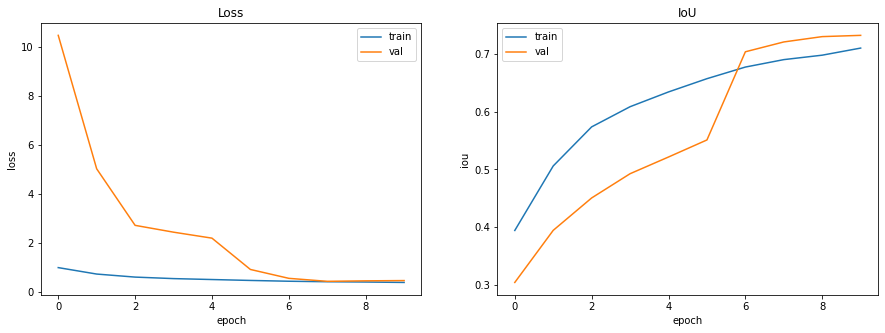

In [9]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['iou'], label='train')
plt.plot(history['val_iou'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('iou')
plt.title("IoU")
plt.show()
#그래프 양상이 IoU 우상향 -> 에폭수만 훨 늘려도 성능이 올라갈 것이라는걸 알 수 있음
#0.73정도의 IoU => 적당

In [8]:
for images, masks in valid_generator:
    break

In [9]:
preds = model.predict(images)

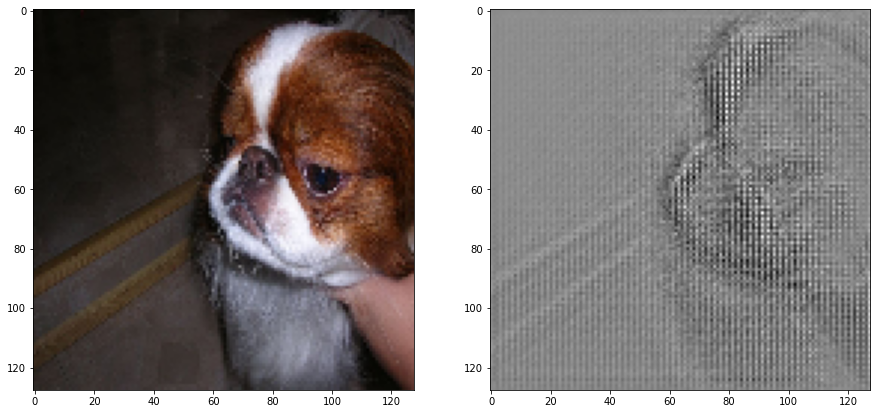

In [12]:
import random
idx = random.choice(range(len(preds)))
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(images[idx, ...])
plt.subplot(1, 2, 2)
plt.imshow(preds[idx, ..., 0], cmap='gray')